In [1]:
import os
from io import StringIO
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt

from src.documentTableProcessor import DocumentTableProcessor

from dotenv import load_dotenv
load_dotenv() 


/home/martin/miniconda3/envs/table-transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
document_table_processor = DocumentTableProcessor(
    det_device=os.environ['TABLE_DETECTION_DEVICE'],
    str_device=os.environ['TABLE_STRUCTURE_DEVICE'], 
    ocr_device=os.environ['READER_DEVICE'],
    ocr_language=os.environ['READER_LANGUAGE']
)

Using CPU. Note: This module is much faster with a GPU.


In [3]:
def side_by_side_plot(img1, img2): 
    f, axarr = plt.subplots(1, 2, figsize=(16,9))
    axarr[0].imshow( img1 )
    axarr[1].imshow( img2 )

    axarr[1].axis('off')
    axarr[0].axis('off')
    plt.show()

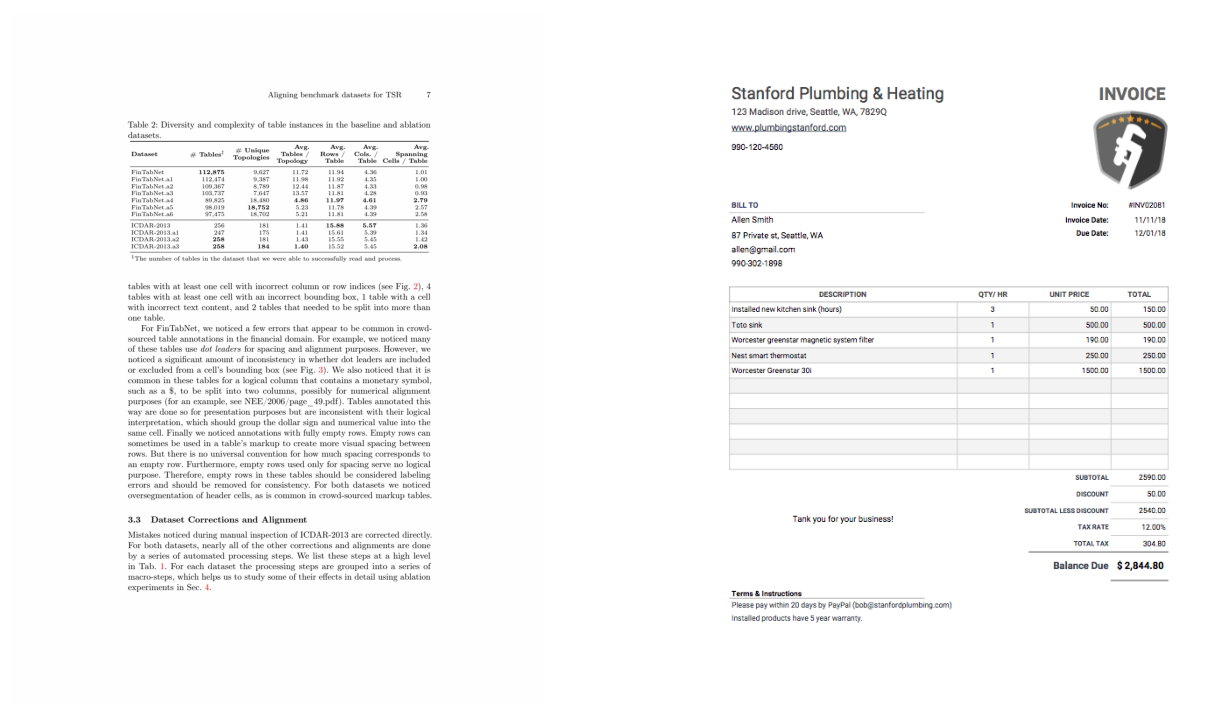

In [4]:
demo_folder_name = 'demo_files/'
invoice_img_file_name = 'Sample-Invoice-printable.jpg'
paper_img_file_name = '2303_00716.jpg'

invoice_img_file_path = demo_folder_name + invoice_img_file_name
paper_img_file_path = demo_folder_name + paper_img_file_name 

paper_image = Image.open(paper_img_file_path)
invoice_image = Image.open(invoice_img_file_path)

side_by_side_plot(paper_image, invoice_image)

Multiple approaches  can be evaluated:
- **OCR the Entire Document**: This approach involves performing OCR on the whole document and subsequently passing the extracted tokens through the processing pipeline. This method is expected to be effective as the extract method reassigns tokens with the output from the previous step in the pipeline. However, this method can be computationally expensive and time-consuming, especially for large documents. On top of this, non-relevant parts of the document may introduce noise that can affect the accuracy of table extraction. 

- **OCR Cropped Tables**: By focusing the OCR process on cropped tables, the extracted tokens can be directly fed into the recognition function. This targeted approach ensures that only relevant data is processed, potentially improving both speed and accuracy.

- **OCR Individual Cells**: As demonstrated in this [tutorial by Niels Rogge](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Inference_with_Table_Transformer_(TATR)_for_parsing_tables.ipynb), OCR can be applied to each cell individually. I will not cover this method as it presumes that tokens are obtained following the table structure extraction. However, the positional information of tokens significantly aids in structure detection, as demonstrated by the `tableTransformer.src.inference.objects_to_structures` function.


I'm using [EasyOCR](www.jaided.ai/easyocr/) to get tokens from images: 
- You can find here the documentation: http://www.jaided.ai/easyocr/documentation/   
- Here is a nice Quickstart Tutorial: https://medium.com/@adityamahajan.work/easyocr-a-comprehensive-guide-5ff1cb850168

Additional ressources: 
- Improve noisy image quality: https://github.com/microsoft/table-transformer/discussions/146
- Generate tokens for image and pdf: https://github.com/microsoft/table-transformer/issues/121
- Fix punctuation and missing numbers by providing `low_text=0.3` to the reader: https://stackoverflow.com/questions/77738509/easyocr-does-not-recognize-this-number-in-an-image
- Fix number recognition issues by providing mag_ratio=2: https://github.com/JaidedAI/EasyOCR/issues/254#issuecomment-1267379900


## OCR the whole document

### One step table extraction 

In [5]:
readtext_args = {'low_text': 0.3} # 'mag_ratio': 2.0

LOG_VIZUALISE = True
LOG_VERBOSE = False

ONE_STEP_EXTRACT_LOG_DIR = 'outputs/one_step_extraction/'

log_options = {
    'image_filename': paper_img_file_name,
    'log_dir':ONE_STEP_EXTRACT_LOG_DIR,
    'vizualise':LOG_VIZUALISE,
    'verbose':LOG_VERBOSE
}

out_options = {
    'out_objects': True,
    'out_cells': True,
    'out_html': True,
    'out_csv': True
}

document_table_processor.ocr_strategy='early'

paper_extracted_tables = document_table_processor.extract(
    image=paper_image,
    readtext_args=readtext_args,
    out_options=out_options,
    log=True,
    log_options=log_options
)

log_options['image_filename'] = invoice_img_file_name

invoice_extracted_tables = document_table_processor.extract(
    image=invoice_image,
    readtext_args=readtext_args,
    out_options=out_options,
    log=True,
    log_options=log_options
)

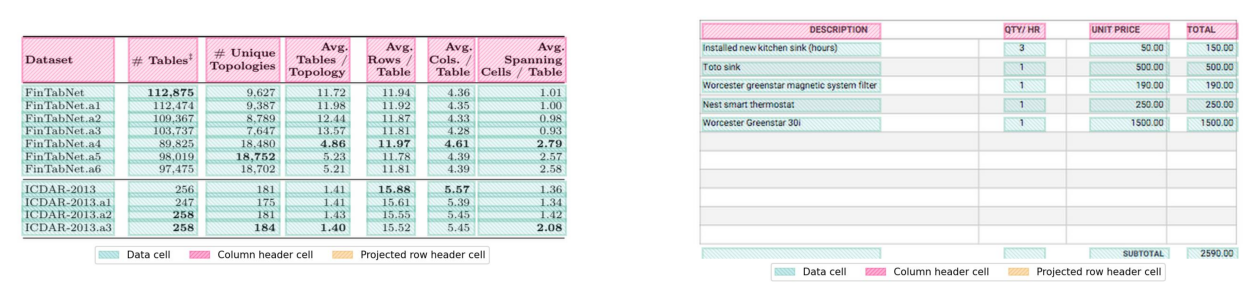

In [6]:
paper_result_one_step_fig_cells = Image.open(ONE_STEP_EXTRACT_LOG_DIR + paper_img_file_name.replace('.jpg', '_crop_0_fig_cells.jpg'))
invoice_result_one_step_fig_cells = Image.open(ONE_STEP_EXTRACT_LOG_DIR + invoice_img_file_name.replace('.jpg', '_crop_0_fig_cells.jpg'))

side_by_side_plot(paper_result_one_step_fig_cells, invoice_result_one_step_fig_cells)

In [7]:
csv_buffer = StringIO(paper_extracted_tables[0]['csv'][0])
pd.read_csv(csv_buffer)

,Dataset,# Tablest,# Unique Topologies,Tables Topology Avg:,Rows Table Avg:,Cols. Table Avg;,Spanning Cells Table Avg:
0,Fin TabNet,"112,875","9,627",11.72,11.94,4.36,1.01
1,FinTabNet.al,"112,474","9,387",11.98,11.92,4.35,1.00
2,Fin TabNel.a2,109.367,"8,789",12.44,11.87,4.33,0.98
3,Fin TabNel.a3,"103,737","7,647",13.57,11.81,4.28,0.93
4,FinTabNet.a4,"89,825","18,480",4.86,11.97,4.61,2.79
5,Fin TabNet.a5,"98,019","18,752",5.23,11.78,4.39,2.57
6,Fin TabNet.a6,"97,475","18,702",5.21,11.81,4.39,2.58
7,ICDAR-2013,256,181,1.41,15.88,5.57,1.36
8,ICDAR-2013.al,247,175,1.41,15.61,5.39,1.34
9,ICDAR-2013.a2,258,181,1.43,15.55,5.45,1.42


In [8]:
csv_buffer = StringIO(invoice_extracted_tables[0]['csv'][0])
pd.read_csv(csv_buffer)

,DESCRIPTIOM,QTyi HR,UNIT PRICE,Totil
0,Instel nenkitchen sink (hours),NaN,53.j0,IS0cj
1,Toto sik,NaN,SCiCO,sodL
2,Worcese greenster megnejic sys em filzer,NaN,151j0,190.CJ
3,Hedsmanthernoste;,NaN,251 j0,250.0J
4,Worces er Greens:er 301,NaN,15C3.*0,1s00.CI
5,NaN,NaN,SULTOTAL,2590cj


## OCR only the cropped tables

### Two Steps table extraction

In [9]:
TWO_STEPS_EXTRACT_LOG_DIR = 'outputs/two_steps_extraction/'

log_options['log_dir'] = TWO_STEPS_EXTRACT_LOG_DIR
log_options['image_filename'] = paper_img_file_name

document_table_processor.ocr_strategy='mid'

paper_extracted_tables = document_table_processor.extract(
    image=paper_image,
    readtext_args=readtext_args,
    out_options=out_options,
    log=True,
    log_options=log_options
)

log_options['image_filename'] = invoice_img_file_name

invoice_extracted_tables = document_table_processor.extract(
    image=invoice_image,
    readtext_args=readtext_args,
    out_options=out_options,
    log=True,
    log_options=log_options
)

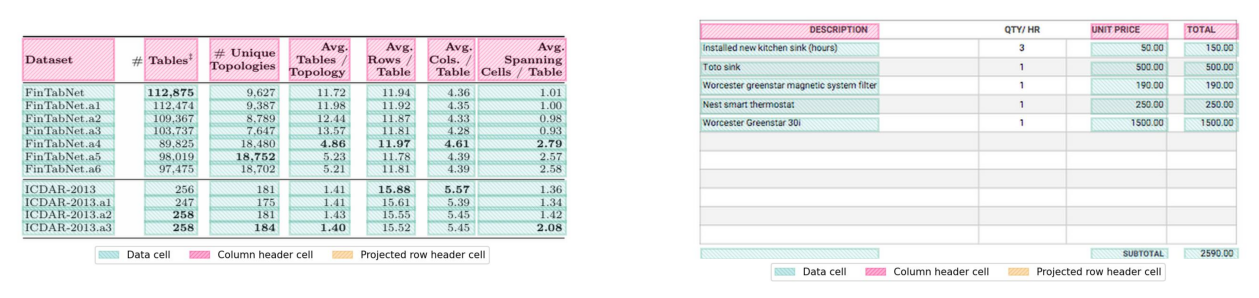

In [10]:
paper_result_two_steps_fig_cells = Image.open(TWO_STEPS_EXTRACT_LOG_DIR + paper_img_file_name.replace('.jpg', '_crop_0_fig_cells.jpg'))
invoice_result_two_steps_fig_cells = Image.open(TWO_STEPS_EXTRACT_LOG_DIR + invoice_img_file_name.replace('.jpg', '_crop_0_fig_cells.jpg'))

side_by_side_plot(paper_result_two_steps_fig_cells, invoice_result_two_steps_fig_cells)

In [11]:
csv_buffer = StringIO(paper_extracted_tables[0]['csv'][0])
pd.read_csv(csv_buffer)

,Dataset,Tables',# Unique Topologies,Tables Topology Avg;,Rows Table Avg;,Cols. Table Avg:,Spanning Cells Table Avg:
0,FinTabNet,"112,875","9,627",11.72,11.94,4.36,1.01
1,Fin TabNet.al,"112,474","9,387",11.98,11.92,4.35,1.00
2,FinTabNet.a2,"109,367","8,789",12.44,11.87,4.33,0.98
3,FinTabNet.a3,"103,737","7,647",13.57,11.81,4.28,0.93
4,FinTabNet.a4,"89,825","18,480",4.86,11.97,4.61,2.79
5,Fin TabNet.a5,"98,019","18,752",5.23,11.78,4.39,2.57
6,FinTabNet.a6,"97,475","18,702",5.21,11.81,4.39,2.58
7,ICDAR-2013,256,181,1.41,15.88,5.57,1.36
8,ICDAR-2013.al,247,175,1.41,15.61,5.39,1.34
9,ICDAR-2013.a2,258,181,1.43,15.55,5.45,1.42


In [12]:
csv_buffer = StringIO(invoice_extracted_tables[0]['csv'][0])
pd.read_csv(csv_buffer)

,DESCRIPTION,UHTT PRICE,TOTAL
0,Instelled nenkitchen sink thours),5100,Is0.C3
1,Totc sik,SCiCO,SoDCZ
2,Worces:er greenster megnejic sys em tilter,15100,190.03
3,smantheroste;,251.W0,250.0J
4,Worces:er Greens:er 301,1s03.j0,1s00.0J
5,NaN,SULTOTAL,2590CJ


The table extracted from a research paper demonstrates that the main difference between one-step and two-step extraction lies in column distribution, particularly in tight layouts. With one-step extraction, the columns are wider and tend to overlap more than in the two-step method.

However, for the tested invoice image, both extraction methods perform poorly. In the one-step approach, all columns are detected, while the two-step process misses a central column. The OCR result is inconsistent, particularly struggling to recognize digits, likely due to the poor quality of the document.

## Handling one page PDFs 

In [13]:
# code from https://github.com/microsoft/table-transformer/issues/121

import fitz
from pathlib import Path

pdf_path = Path("demo_files/T&T Annexe 1.pdf")
pdf = fitz.open(stream=pdf_path.read_bytes(), filetype="pdf")

extracted_tables = document_table_processor.extract_pdf(pdf)

csv_buffer = StringIO(extracted_tables[0]['csv'][0])
pd.read_csv(csv_buffer)

,2D6,Tableau 5 : Complications
0,2,L'intervention des aventuriers doit rester sec...
1,3,Un traître se trouve parmi les alliés des PJs
2,4,Les aventuriers ont perdu la mémoire
3,5,Innocents/ressources doivent être sacrifié(e)s
4,6,Le temps des aventuriers pour agir est compté
5,7,Les aventuriers sont suivis par un autre groupe
6,8,Les aventuriers ont changé de corps
7,9,Les aventuriers n'ont pas leur équipement
8,10,Les méchants sont les gentils et vice-versa
9,11,Une partie des PNJs sont des rêves/illusions


In [14]:
len(extracted_tables)

5

In [16]:
type(pdf)

fitz.fitz.Document

In [15]:
for table in extracted_tables: 
    display(pd.read_csv(StringIO(table['csv'][0])))


,2D6,Tableau 5 : Complications
0,2,L'intervention des aventuriers doit rester sec...
1,3,Un traître se trouve parmi les alliés des PJs
2,4,Les aventuriers ont perdu la mémoire
3,5,Innocents/ressources doivent être sacrifié(e)s
4,6,Le temps des aventuriers pour agir est compté
5,7,Les aventuriers sont suivis par un autre groupe
6,8,Les aventuriers ont changé de corps
7,9,Les aventuriers n'ont pas leur équipement
8,10,Les méchants sont les gentils et vice-versa
9,11,Une partie des PNJs sont des rêves/illusions


,Unnamed: 0,Unnamed: 1
0,3,Disparition d'un objet/ d'un lieu/ d'individus
1,4,"Vagues de crimes (vols, assassinats, rackets...)"
2,5,"Découverte de ruines, d'un gisement d'or..."
3,6,Méprise sur l'identité des aventuriers
4,7,Escarmouches le long de la frontière
5,8,Révolte/Soulèvement/Guerre civile
6,9,"Phénomène étrange (météorite, éclipse sans fin)"
7,10,Siège
8,11,Menace/attaque directe contre les aventuriers
9,12,"Négociations difficiles (pays, guildes, cités...)"


,3D6,Tableau 1 : Lieu
0,3,Dans une auberge
1,4,Dans un monastère
2,5,Dans un village en ruine
3,6,Au marché d'une grande cité
4,7,À cheval dans une plaine
5,8,En train d'escalader une montagne
6,9,Sur un navire
7,10,Chez une voyante
8,11,En plein(e) tempête/blizzard/déluge
9,12,À une fête populaire


,2D6,Tableau 3a,2D6.1,Tableau 3b
0,2,Érudits/Mages...,2,...Hommes serpents
1,3,Nobles...,3,...Elfes
2,4,Brigands...,4,...Humains
3,5,Cultistes...,5,...Drakkens
4,6,Déserteurs...,6,...Nains
5,7,Marchands...,7,...Sangrelins
6,8,Un ancien dieu...,8,...Halflings
7,9,Mort-vivants...,9,...Visage-miroirs
8,10,Assassins...,10,...Wolfens
9,11,Une relique...,11,...Krislings


,3D6,Tableau 4 : Action
0,3,Participer à un tournoi/un concours
1,4,Retrouver/Voler/Capturer un objet/un individu
2,5,Protéger un lieu
3,6,Conquérir/nettoyer un lieu
4,7,Aider/Empêcher une alliance/des négociations
5,8,Explorer un lieu/territoire/plan inconnu
6,9,Escorter un objet/individu
7,10,Trouver l'identité des coupables
8,11,Découvrir les plans de l'adversaire
9,12,Gérer un commerce/un village/un convoi
